## Display function

In [1]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [2]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Function for filtering the result_list

In [3]:
import numpy as np
from sklearn.metrics import roc_curve
def filter_roc_results(results_list, results_original_roc, depth=1):
    """
    Filters the ROC results to include only those that are better than the original ROC curve.
    Each results_list item will compare its TPR against the original ROC curve's TPR at the same FPR.
    This function assumes that the results_list contains dictionaries with 'fpr', 'tpr' keys.
    If the TPR of a model at a given FPR is greater than the original model's TPR,
    it is considered a better model and included in the filtered results.
    If the FPR of a model is not present in the original ROC curve, then extrapolate
    the TPR value from the original ROC curve using linear interpolation.
    If the TPR of a model for a given FPR is equal to or worse than the original model's TPR, then
    we compute ROC results of the previous model in the list and compare the TPR with the original_model TPR for that FPR.
    If the above step still does not yield a better model, then we perform the same operation for the next model in the list.
    If still we do not find a better model, then we pick the original model as the best model for that FPR.
    The depth parameter defines how many models to look back and forward in the list
    to find a substitute model that performs better than the original model at the same FPR. 

    Args:
        results_list: A list of dictionaries containing the ROC results of the models.
        results_original_roc: A dictionary containing the ROC results of the original model.

    Returns:
        A filtered list of dictionaries containing only the relevant ROC results.
    """
    final_roc_points = []
    original_fprs = np.array(results_original_roc['fpr'])
    original_tprs = np.array(results_original_roc['tpr'])
    original_thresholds = np.array(results_original_roc['thresholds'])

    for i, current_data in enumerate(results_list):
        current_fpr = current_data["fpr"]
        current_tpr = current_data["tpr"]
        current_threshold = current_data["threshold"]

        original_tpr_at_current_fpr = np.interp(current_fpr, original_fprs, original_tprs)

        # 1. Is the current model's point better than the baseline?
        if current_tpr > original_tpr_at_current_fpr:
            final_roc_points.append({
                "model": current_data["model"],
                "fpr": current_fpr,
                "tpr": current_tpr,
                "threshold": current_threshold
            })
            continue

        # 2. NO. Search for the best substitute within the defined depth.
        best_substitute = None
        # Start by assuming the baseline is the best we can do. We need to beat this.
        best_substitute_tpr = original_tpr_at_current_fpr

        # Define the search window
        start_index = max(0, i - depth)
        end_index = min(len(results_list), i + depth + 1)

        for j in range(start_index, end_index):
            # Don't compare the model with itself
            if i == j:
                continue

            candidate_data = results_list[j]
            candidate_roc = candidate_data["full_roc"]
            
            # Find the candidate's performance at the current FPR
            candidate_tpr = np.interp(current_fpr, candidate_roc["fpr"], candidate_roc["tpr"])

            # If this candidate is the best substitute found so far...
            if candidate_tpr > best_substitute_tpr:
                best_substitute_tpr = candidate_tpr
                
                # ...find its corresponding threshold and store its info.
                idx = np.searchsorted(candidate_roc["fpr"], current_fpr)
                chosen_threshold = candidate_roc["thresholds"][max(0, idx - 1)]
                best_substitute = {
                    "model": candidate_data["model"],
                    "tpr": candidate_tpr,
                    "threshold": chosen_threshold
                }
        
        # 3. After searching, did we find a worthy substitute?
        if best_substitute:
            # YES. A substitute from the window was better than the baseline.
            best_substitute["fpr"] = current_fpr # Add the FPR to the dict
            final_roc_points.append(best_substitute)
        else:
            # NO. No model in the window was better. Fall back to the baseline.
            idx = np.searchsorted(original_fprs, current_fpr)
            chosen_threshold = original_thresholds[max(0, idx - 1)]
            final_roc_points.append({
                "model": "original_baseline",
                "fpr": current_fpr,
                "tpr": original_tpr_at_current_fpr,
                "threshold": chosen_threshold
            })

    # Find the min and max FPR values in the final results
    # if min FPR is greater than 0, use the operation points from 0 to min FPR of the model with the min FPR to fill the gap
    # we do the same for the max FPR less than 1
     # If no points were selected, return an empty list
    if not final_roc_points:
        return []

    # --- Start of the completed section ---

    # Find the point with the minimum FPR to start the curve
    min_fpr_point = min(final_roc_points, key=lambda x: x['fpr'])
    min_fpr_val = min_fpr_point['fpr']
    min_fpr_model_name = min_fpr_point['model']

    initial_points = []
    if min_fpr_val > 0:
        # Get the full ROC of the model with the minimum FPR
        if min_fpr_model_name == 'original_baseline':
            min_model_roc = results_original_roc
        else:
            min_model_data = next((item for item in results_list if item['model'] == min_fpr_model_name), None)
            min_model_roc = min_model_data['full_roc'] if min_model_data else None

        if min_model_roc:
            roc_fprs = np.array(min_model_roc['fpr'])
            roc_tprs = np.array(min_model_roc['tpr'])
            roc_thresholds = np.array(min_model_roc['thresholds'])
            
            indices_to_add = np.where(roc_fprs < min_fpr_val)[0]
            for idx in indices_to_add:
                initial_points.append({
                    "model": min_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Find the point with the maximum FPR to end the curve
    max_fpr_point = max(final_roc_points, key=lambda x: x['fpr'])
    max_fpr_val = max_fpr_point['fpr']
    max_fpr_model_name = max_fpr_point['model']
    
    trailing_points = []
    if max_fpr_val < 1.0:
        # Get the full ROC of the model with the maximum FPR
        if max_fpr_model_name == 'original_baseline':
            max_model_roc = results_original_roc
        else:
            max_model_data = next((item for item in results_list if item['model'] == max_fpr_model_name), None)
            max_model_roc = max_model_data['full_roc'] if max_model_data else None
        
        if max_model_roc:
            roc_fprs = np.array(max_model_roc['fpr'])
            roc_tprs = np.array(max_model_roc['tpr'])
            roc_thresholds = np.array(max_model_roc['thresholds'])

            indices_to_add = np.where(roc_fprs > max_fpr_val)[0]
            for idx in indices_to_add:
                trailing_points.append({
                    "model": max_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Combine all points
    combined_points = initial_points + final_roc_points + trailing_points

    # Sort by FPR (and then by descending TPR to keep the best point) and remove duplicates
    combined_points.sort(key=lambda p: (p['fpr'], -p['tpr']))
    
    unique_roc_points = []
    seen_fprs = set()
    for point in combined_points:
        if point['fpr'] not in seen_fprs:
            unique_roc_points.append(point)
            seen_fprs.add(point['fpr'])

    return unique_roc_points

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## PneumoniaMNIST: NN

In [6]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [7]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x

### Lightning module

In [9]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val,
            "thresholds": thresholds.cpu(),
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Generate data

In [10]:
train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")

# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

3.0.2
Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["fpr"], "tpr": results_phase1["tpr"], "thresholds": results_phase1["thresholds"], "name": "Original NN PneumoniaMNIST", "auc": results_phase1["auc"], "model": model}

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- Starting Training for 1 epochs on train_loader ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v6.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v6.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v6.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Test Metrics ---
Accuracy: 0.8574
AUC: 0.9215
Precision: 0.8413
Recall: 0.9513
F1-Score: 0.8929
Confusion Matrix:
tensor([[164,  70],
        [ 19, 371]], device='cuda:0')
--------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8573718070983887
     test_auc_epoch         0.9215428233146667
        test_loss           0.3700076639652252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Weighted ROC curve

In [12]:
NUM_CLASSIFIERS = 50
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage



# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

for i, pos_weight in enumerate(pos_weights):
    model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'checkpoints/stage_{i+1}/',
        filename=f'best-model-{{epoch:02d}}-{{val_acc:.2f}}',
        save_top_k=1,
        mode='max',
    )
    
    # 3. Instantiate a NEW Trainer for this specific stage
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        #strategy='ddp_notebook',
        max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_ratio_{pos_weight}"),
        precision='16-mixed'
        )
    
    # 4. Train the model. It will start with weights from the previous stage.
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    # 5. Get the path to the best model from THIS stage and store it
    if checkpoint_callback.best_model_path:
        best_path_this_stage = checkpoint_callback.best_model_path
        print(f"--- Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
        best_model_paths.append(best_path_this_stage)
        
        # 6. CRITICAL: Load the best weights back into the model object
        # This ensures we carry forward the BEST model to the next stage, not the last.
        print(f"Loading best weights from {best_path_this_stage} to continue...")
        model = LitSimpleCNN.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
    else:
        print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
        # If no checkpoint was saved, the model object will just have the weights from the last epoch.


Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v19.ckpt to continue...


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAURO

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.66-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.66-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.93-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.93-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.92-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.92-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.95-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.95-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.97-v5.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.97-v5.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.97-v5.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.97-v5.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.95-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.95-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.98-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.98-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.98-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.98-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.97-v6.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.97-v6.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.98-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.98-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.95-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.95-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.98-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.98-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97-v6.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97-v6.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-val_acc=0.97-v5.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-val_acc=0.97-v5.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-val_acc=0.97-v5.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-val_acc=0.97-v5.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-val_acc=0.96-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-val_acc=0.96-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-val_acc=0.95-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-val_acc=0.95-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.92-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.92-v4.ckpt to continue...


### Test the classifiers

In [14]:
# ===================================================================
# --- FINAL STEP: Evaluating All Trained Models (Corrected) ---
# ===================================================================
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import torch
import torchmetrics

print("\n--- FINAL STEP: Evaluating all saved models ---")

list_weighted_clfs = []

# Loop through each saved model checkpoint
for i, checkpoint_path in enumerate(best_model_paths):
    print(f"\n--- Testing model from checkpoint: {checkpoint_path} ---")

    # 1. Load the PyTorch model from the checkpoint
    pytorch_model = LitSimpleCNN.load_from_checkpoint(checkpoint_path, strict=False)
    pytorch_model.eval()  # Set model to evaluation mode
    pytorch_model.to('cuda:0') # Move model to GPU

    # --- Generate Predictions for the ENTIRE test set ---
    # We will collect the raw model outputs (logits) and true labels
    all_logits = []
    all_labels = []

    # Wrap the loop in torch.no_grad() for efficiency
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Predicting with model {i+1}"):
            inputs, labels = batch
            
            # Move data to the GPU
            inputs = inputs.to('cuda:0')
            
            # Get model output (raw logits) for the batch
            logits = pytorch_model(inputs)
            
            # Append batch results to lists (move back to CPU to prevent GPU memory buildup)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batch results into single tensors
    # These now contain the predictions and labels for the full test set
    full_dataset_logits = torch.cat(all_logits)
    full_dataset_labels = torch.cat(all_labels).int() # Ensure labels are integers

    # --- Now, Calculate ALL Metrics using the generated predictions ---

    # 2. Calculate the full ROC curve data
    # Use the raw logits, torchmetrics will handle applying all thresholds
    array_of_all_fprs, array_of_all_tprs, threshold_vals = torchmetrics.functional.roc(
        preds=full_dataset_logits,
        target=full_dataset_labels,
        task="binary"
    )

    # 3. Calculate confusion matrix based on a hard threshold (e.g., 0.5)
    # Note: The model outputs logits, so the threshold 0.5 for probabilities corresponds to 0.0 for logits.
    hard_preds = (full_dataset_logits > 0.0).int().numpy()
    tn, fp, fn, tp = confusion_matrix(full_dataset_labels.numpy(), hard_preds).ravel()

    # 4. Calculate metrics from the confusion matrix
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # This is also Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    print(f"Results at threshold 0.5: TPR={tpr:.4f}, FPR={fpr:.4f}, F1-Score={f1:.4f}")
    
    # 5. Store the comprehensive results for this model
    list_weighted_clfs.append({
        "fpr": fpr,
        "tpr": tpr,
        "model": pytorch_model, # Optional: store the model object itself
        "threshold": 0.5,
        "full_roc": {
            "fpr": array_of_all_fprs,
            "tpr": array_of_all_tprs,
            "thresholds": threshold_vals
        }
    })


--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v19.ckpt ---


Predicting with model 1: 100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Results at threshold 0.5: TPR=0.0077, FPR=0.0000, F1-Score=0.0153

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.66-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 2: 100%|██████████| 10/10 [00:00<00:00, 12.02it/s]


Results at threshold 0.5: TPR=0.5564, FPR=0.0470, F1-Score=0.7023

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.93-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 3: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


Results at threshold 0.5: TPR=0.9282, FPR=0.1538, F1-Score=0.9188

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 4: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Results at threshold 0.5: TPR=0.9795, FPR=0.3034, F1-Score=0.9063

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.92-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 5: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s]


Results at threshold 0.5: TPR=0.9410, FPR=0.1453, F1-Score=0.9279

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.95-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 6: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]


Results at threshold 0.5: TPR=0.9718, FPR=0.3205, F1-Score=0.8981

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.97-v5.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 7: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s]


Results at threshold 0.5: TPR=0.9821, FPR=0.3974, F1-Score=0.8845

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.97-v5.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 8: 100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.4145, F1-Score=0.8830

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.95-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 9: 100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Results at threshold 0.5: TPR=0.9564, FPR=0.1624, F1-Score=0.9313

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 10: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]


Results at threshold 0.5: TPR=0.9718, FPR=0.2308, F1-Score=0.9210

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.98-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 11: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Results at threshold 0.5: TPR=0.9846, FPR=0.3162, F1-Score=0.9057

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 12: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.4444, F1-Score=0.8798

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 13: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s]


Results at threshold 0.5: TPR=0.9821, FPR=0.3974, F1-Score=0.8845

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 14: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]


Results at threshold 0.5: TPR=0.9897, FPR=0.3974, F1-Score=0.8884

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 15: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


Results at threshold 0.5: TPR=0.9821, FPR=0.3889, F1-Score=0.8866

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 16: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.3932, F1-Score=0.8881

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 17: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s]


Results at threshold 0.5: TPR=0.9846, FPR=0.4274, F1-Score=0.8787

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 18: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


Results at threshold 0.5: TPR=0.9846, FPR=0.4359, F1-Score=0.8767

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v7.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 19: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


Results at threshold 0.5: TPR=0.9769, FPR=0.3462, F1-Score=0.8944

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v7.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 20: 100%|██████████| 10/10 [00:00<00:00, 13.84it/s]


Results at threshold 0.5: TPR=0.9795, FPR=0.3333, F1-Score=0.8988

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.98-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 21: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.3846, F1-Score=0.8902

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v7.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 22: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s]


Results at threshold 0.5: TPR=0.9846, FPR=0.2863, F1-Score=0.9132

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 23: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Results at threshold 0.5: TPR=0.9744, FPR=0.3162, F1-Score=0.9005

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v7.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 24: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s]


Results at threshold 0.5: TPR=0.9897, FPR=0.4615, F1-Score=0.8733

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 25: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.6026, F1-Score=0.8469

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 26: 100%|██████████| 10/10 [00:00<00:00, 13.39it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.4744, F1-Score=0.8691

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v7.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 27: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


Results at threshold 0.5: TPR=0.9897, FPR=0.4573, F1-Score=0.8743

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 28: 100%|██████████| 10/10 [00:00<00:00, 12.55it/s]


Results at threshold 0.5: TPR=0.9897, FPR=0.4274, F1-Score=0.8813

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 29: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.4487, F1-Score=0.8801

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 30: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.4829, F1-Score=0.8709

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.97-v6.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 31: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.5171, F1-Score=0.8632

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 32: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.4316, F1-Score=0.8828

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 33: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.4872, F1-Score=0.8725

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.98-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 34: 100%|██████████| 10/10 [00:00<00:00, 14.63it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.4487, F1-Score=0.8788

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 35: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4487, F1-Score=0.8776

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.95-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 36: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s]


Results at threshold 0.5: TPR=0.9769, FPR=0.2778, F1-Score=0.9115

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.98-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 37: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.4274, F1-Score=0.8851

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 38: 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.5897, F1-Score=0.8484

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 39: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.4402, F1-Score=0.8770

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 40: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]


Results at threshold 0.5: TPR=0.9949, FPR=0.6026, F1-Score=0.8444

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 41: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4786, F1-Score=0.8706

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97-v6.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 42: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4701, F1-Score=0.8726

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-val_acc=0.97-v5.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 43: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Results at threshold 0.5: TPR=0.9846, FPR=0.4188, F1-Score=0.8807

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 44: 100%|██████████| 10/10 [00:00<00:00, 14.16it/s]


Results at threshold 0.5: TPR=0.9821, FPR=0.3718, F1-Score=0.8907

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-val_acc=0.97-v5.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 45: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4615, F1-Score=0.8746

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 46: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.6154, F1-Score=0.8429

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-val_acc=0.96-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 47: 100%|██████████| 10/10 [00:00<00:00, 13.56it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.5983, F1-Score=0.8466

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 48: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.4829, F1-Score=0.8722

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-val_acc=0.95-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 49: 100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.6325, F1-Score=0.8393

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.92-v4.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Predicting with model 50: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]

Results at threshold 0.5: TPR=0.9974, FPR=0.8120, F1-Score=0.8029


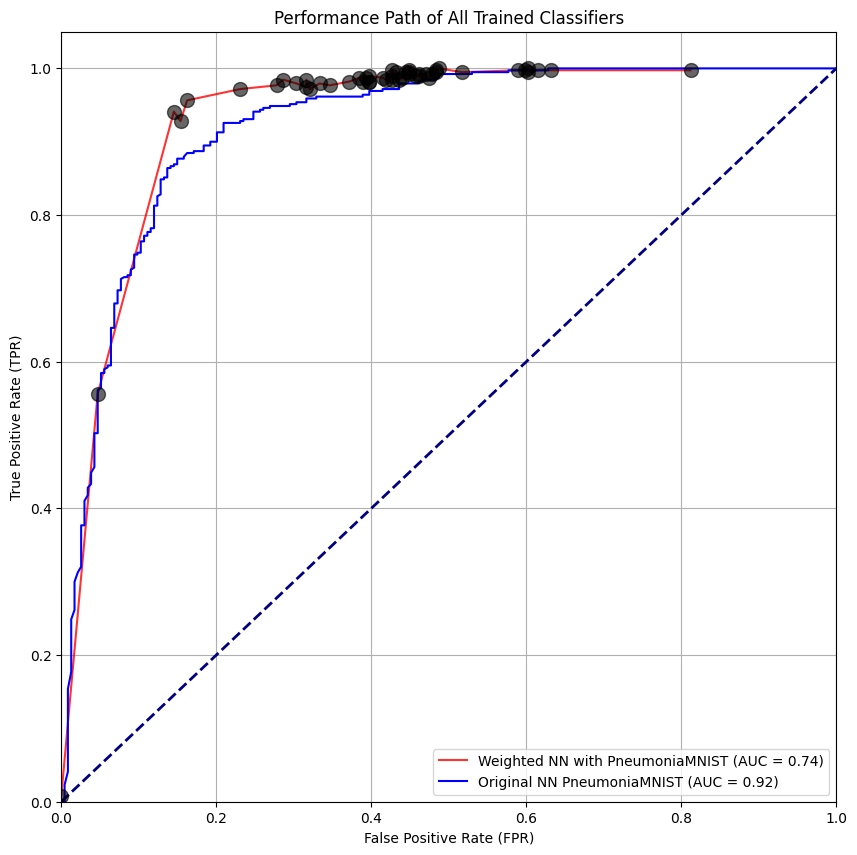

In [15]:
plot_roc_connected_points(list_weighted_clfs, results_original_roc, name="Weighted NN with PneumoniaMNIST")

/tmp/ipykernel_54301/3800948716.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_fprs = np.array(results_original_roc['fpr'])
/tmp/ipykernel_54301/3800948716.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_tprs = np.array(results_original_roc['tpr'])
/tmp/ipykernel_54301/3800948716.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_thresholds = np.array(results_original_roc['thresholds'])
/tmp/ipykernel_54301/3800948716.py:149: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keywo

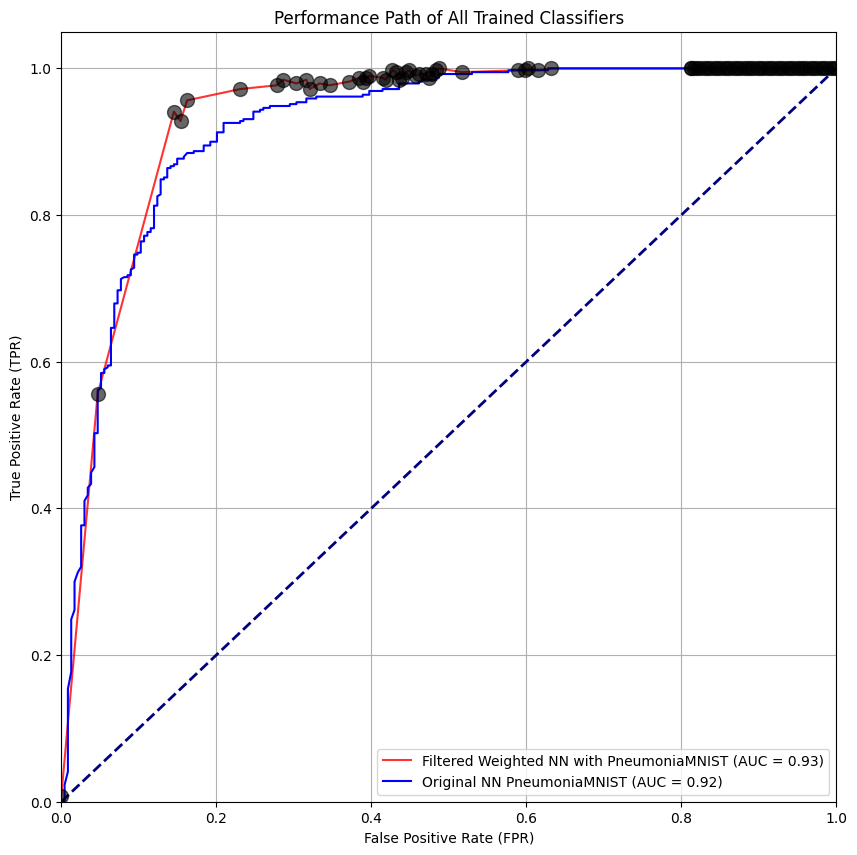

In [16]:
#filter the results
filtered_results = filter_roc_results(list_weighted_clfs, results_original_roc, depth=1)
# Plot the filtered results
plot_roc_connected_points(filtered_results, results_original_roc, name="Filtered Weighted NN with PneumoniaMNIST")

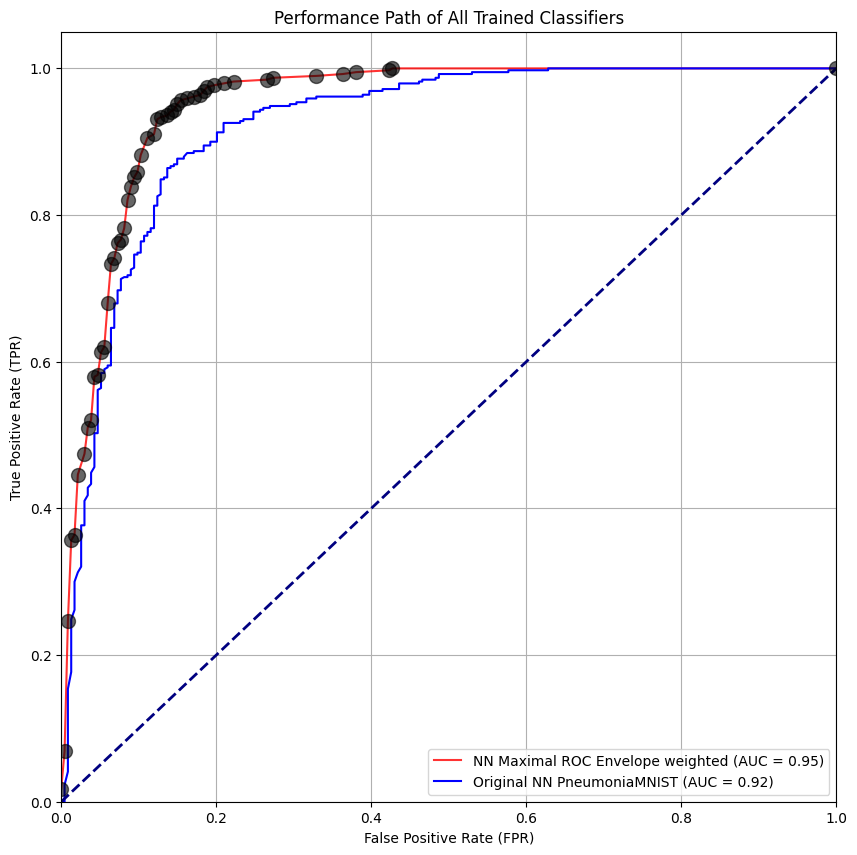

In [17]:
best_envelope = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
# Plot the best ROC envelope
plot_roc_connected_points(best_envelope, results_original_roc, name="NN Maximal ROC Envelope weighted")